In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from matplotlib import colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.base import clone

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
import numpy as np
import pandas as pd
df_cant = pd.read_csv('dfVarCat.csv')
df_saldo = pd.read_csv('dfVarSaldo.csv')
df_revol_venc = pd.read_csv('df_RESUMEN_revol_ven.csv')
df = pd.read_csv('customers.csv')
customers = df.drop(['NO_DEPARTAMENTO','NO_PROVINCIA'], axis=1)
target_train = pd.read_csv('train.csv')
PROBA_TARGET = pd.read_csv('PROB_TARGET.csv')

In [6]:
PROBA_TARGET

ID      PROB
0      00683cec6b3a417f9565872d62ca3d61  0.112368
1      a6cefaf88b254685a87ae2575c6eafe8  0.900425
2      3e8b6439ecb648d09af7d95e6665771f  0.032240
3      48eef4aff3e946088b6cf6cb8b88e64e  0.034043
4      c0968a0e84f3403caa3d23b01e3dee8e  0.038073
...                                 ...       ...
27350  ba627fb71a7e4df68e739f87f924364f  0.291167
27351  2e4594168eef4a278c7ebfbf7d60d2ed  0.208954
27352  5c3646ba39be4b148697ff200a309b4a  0.129560
27353  b005789382ba4880b489f5b04a33a13d  0.004744
27354  437bd7ed1e084524a5083a2aab8276e0  0.025945

[27355 rows x 2 columns]

In [11]:
A = pd.merge(target_train, PROBA_TARGET, on ='ID', how='inner')
A.to_csv('Ren')

In [13]:
A

ID  TARGET      PROB
0      e16fa03a0e364fe7942c1d2e77eeca22       0  0.488927
1      122350d870e04db783f78bf18a09ca42       0  0.060111
2      d6560b1d7e46494da8bd6de840af411c       0  0.097138
3      e78acaffa7424b22a107eae030b9d62c       0  0.163939
4      3e5c45895af24a578db4690608a03499       0  0.158934
...                                 ...     ...       ...
27350  7b7457b419544a3bafa9118694e9d5d9       0  0.079636
27351  4628b9aa767d4df59c781d8336c7d3c3       0  0.225140
27352  ebe860b3c5d94aef90916f92ec5860fd       0  0.053660
27353  5b3075f2144a429580916e115112637f       0  0.029433
27354  04101bb15a62417aba29206e19cb9660       0  0.104092

[27355 rows x 3 columns]

In [16]:
frecuencia_1s = df.groupby('Decil')['Target'].mean()
frecuencia_1s

Decil
1     0.010234
2     0.027422
3     0.055556
4     0.068373
5     0.087719
6     0.104570
7     0.129609
8     0.183382
9     0.286654
10    0.564327
Name: Target, dtype: float64

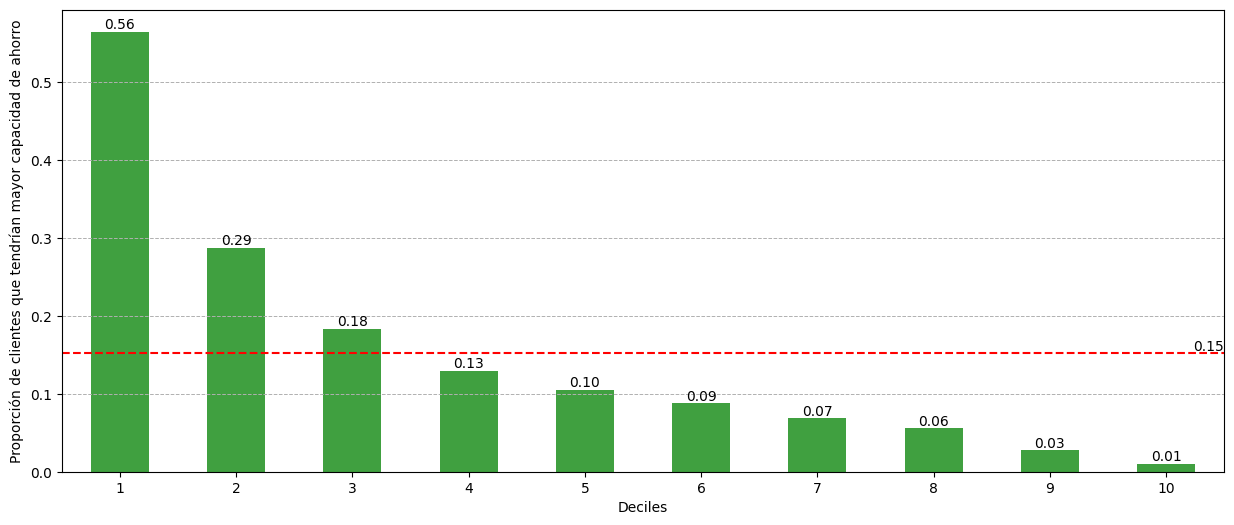

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Simulación de datos
np.random.seed(0)  # Para reproducibilidad
probabilidades = A['PROB']  # 1000 probabilidades simuladas
target = A['TARGET']  # 1000 valores de target (0 y 1)

# Crear DataFrame
df = pd.DataFrame({'Probabilidades': probabilidades, 'Target': target})

# Calcular deciles
df['Decil'] = pd.qcut(df['Probabilidades'], 10, labels=False)
# Invertir el orden de los deciles
max_decil = df['Decil'].max()
df['Decil'] = max_decil - df['Decil'] + 1

# Calcular la frecuencia de 1s por decil
frecuencia_1s = df.groupby('Decil')['Target'].mean()

# Calcular el porcentaje total de 1s
porcentaje_total_1s = df['Target'].mean()

# Graficar
plt.figure(figsize=(15, 6))
grafico = frecuencia_1s.plot(kind='bar', color='green', alpha=0.75)
plt.axhline(y=porcentaje_total_1s, color='r', linestyle='--')
plt.xlabel('Deciles')
plt.ylabel('Proporción de clientes que tendrían mayor capacidad de ahorro')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', linewidth=0.7)

# Etiquetas de datos
for i, valor in enumerate(frecuencia_1s):
    plt.annotate(f'{valor:.2f}', xy=(i, valor), ha='center', va='bottom')

# Etiqueta del porcentaje total de 1s
plt.text(9.5, porcentaje_total_1s, f'{porcentaje_total_1s:.2f}', ha='right', va='bottom')

plt.show()


In [3]:
df_merge = pd.merge(df_cant,df_saldo,on='ID')
df_merge = pd.merge(df_revol_venc,df_merge,on='ID')
df_merge = pd.merge(customers,df_merge,on='ID')
df_merge = pd.merge(target_train,df_merge,on='ID',how='left')
print(df_cant.shape)
print(target_train.shape)
print(df_merge.shape)
df_merge


(151972, 241)
(91183, 2)
(91183, 599)


ID  TARGET  CO_TIPO_SEXO  EDAD  \
0      f7c7ee28b72e48eeb8400fcf7f1a9648       1             2  62.0   
1      baea8933cb264255a9c05da02f43daac       0             1  46.0   
2      3ed19bff6c284d89a18efdf316e65ac7       1             3  35.0   
3      e16fa03a0e364fe7942c1d2e77eeca22       0             1  44.0   
4      db45d12bf28148f384b0d39c0f4a9e0e       0             1  50.0   
...                                 ...     ...           ...   ...   
91178  04101bb15a62417aba29206e19cb9660       0             2  37.0   
91179  15d2dd2ca8ed4972afd0309af5966c06       0             3  31.0   
91180  8e0e16922867423192be4b40947822c1       1             2  48.0   
91181  f6c24001f7ba459498cfa9e3ce1b1e19       0             1  54.0   
91182  1e1e3ec8d2134a559838fc7210a80705       0             1  63.0   

                                                 DE_CIIU  PER_BANCARIZACION  \
0      OTRAS ACTIVIDADES NO CLASIFICAD.EN OTRA PARTE\r\n             200605   
1      OTRAS ACTIVIDADES NO CLASIFICAD.EN OTRA PARTE\r\n             200612   
2                     OTRAS ACTIVID.DE TIPO SERVICIO NCP             201406   
3                     OTRAS ACTIVID.DE TIPO SERVICIO NCP             200804   
4                      CONSTRUCCION EDIFICIOS COMPLETOS.             200804   
...                                                  ...                ...   
91178  OTRAS ACTIVIDADES NO CLASIFICAD.EN OTRA PARTE\r\n             200706   
91179                     VTA. MIN. EN PUESTOS DE VENTA.             201602   
91180                          ACTIVIDADES INMOBILIARIAS             200601   
91181  OTRAS ACTIVIDADES NO CLASIFICAD.EN OTRA PARTE\r\n             201307   
91182                  CONSTRUCCION EDIFICIOS COMPLETOS.             201607   

       Condicion_cli  CANT_EMP_NEG_mean_2meses  CANT_EMP_NEG_max_2meses  \
0                  4                       1.0                        1   
1                  1                       1.0                        1   
2                  4                       0.0                        0   
3                  4                       0.0                        0   
4                  3                       2.0                        2   
...              ...                       ...                      ...   
91178              4                       0.0                        0   
91179              3                       2.0                        2   
91180              4                       1.0                        1   
91181              1                       1.0                        1   
91182              3                       1.0                        1   

       CANT_EMP_NEG_moda_2meses  ...  SALDO_DOLA_CONS_median_9meses  \
0                             1  ...                            0.0   
1                             1  ...                            0.0   
2                             0  ...                            0.0   
3                             0  ...                            0.0   
4                             2  ...                            0.0   
...                         ...  ...                            ...   
91178                         0  ...                            0.0   
91179                         2  ...                            0.0   
91180                         1  ...                            0.0   
91181                         1  ...                            0.0   
91182                         1  ...                            0.0   

       SALDO_DOLA_CONS_std_9meses  SALDO_DOLA_HIPOT_mean_9meses  \
0                        0.000000                           0.0   
1                        0.000000                           0.0   
2                        0.000000                           0.0   
3                       28.447056                           0.0   
4                        0.000000                           0.0   
...                           ...                           ...   
91178       

In [5]:
df_merge.head(3)

ID  TARGET  CO_TIPO_SEXO  EDAD  \
0  f7c7ee28b72e48eeb8400fcf7f1a9648       1             2  62.0   
1  baea8933cb264255a9c05da02f43daac       0             1  46.0   
2  3ed19bff6c284d89a18efdf316e65ac7       1             3  35.0   

                                             DE_CIIU  PER_BANCARIZACION  \
0  OTRAS ACTIVIDADES NO CLASIFICAD.EN OTRA PARTE\r\n             200605   
1  OTRAS ACTIVIDADES NO CLASIFICAD.EN OTRA PARTE\r\n             200612   
2                 OTRAS ACTIVID.DE TIPO SERVICIO NCP             201406   

   Condicion_cli  CANT_EMP_NEG_mean_2meses  CANT_EMP_NEG_max_2meses  \
0              4                       1.0                        1   
1              1                       1.0                        1   
2              4                       0.0                        0   

   CANT_EMP_NEG_moda_2meses  ...  SALDO_DOLA_CONS_median_9meses  \
0                         1  ...                            0.0   
1                         1  ...                            0.0   
2                         0  ...                            0.0   

   SALDO_DOLA_CONS_std_9meses  SALDO_DOLA_HIPOT_mean_9meses  \
0                         0.0                           0.0   
1                         0.0                           0.0   
2                         0.0                           0.0   

   SALDO_DOLA_HIPOT_max_9meses  SALDO_DOLA_HIPOT_median_9meses  \
0                          0.0                             0.0   
1                          0.0                             0.0   
2                          0.0                             0.0   

   SALDO_DOLA_HIPOT_std_9meses  MAX_LINEA_DISP_U6M_mean_9meses  \
0                          0.0                    25630.000000   
1                          0.0                        0.000000   
2                          0.0                    21816.666667   

   MAX_LINEA_DISP_U6M_max_9meses  MAX_LINEA_DISP_U6M_median_9meses  \
0                        25630.0                           25630.0   
1                            0.0                               0.0   
2                        39270.0                           39270.0   

   MAX_LINEA_DISP_U6M_std_9meses  
0                       0.000000  
1                       0.000000  
2                   20697.107286  

[3 rows x 599 columns]

In [4]:
df_merge = df_merge.drop(['DE_CIIU'],axis = 1)

In [5]:
from datetime import datetime
def calcular_diferencia_mes(periodo_bancarizacion):
    fecha_bancarizacion = datetime.strptime(str(periodo_bancarizacion), "%Y%m")
    fecha_actual = datetime.now()

    diferencia_anios = fecha_actual.year - fecha_bancarizacion.year

    if fecha_actual.month < fecha_bancarizacion.month:
        mesd = (12-fecha_actual.month)+fecha_bancarizacion.month
        diferencia_anios -= 1
    else:
        mesd = (fecha_actual.month-fecha_bancarizacion.month)
    diferencia_mes = 12*diferencia_anios + mesd
    return diferencia_mes

df_merge['Tiempo_Banco'] = df_merge['PER_BANCARIZACION'].apply(calcular_diferencia_mes)
df_merge.drop(['PER_BANCARIZACION'], axis = 1, inplace =True)


In [126]:
df_merge.head(3)

ID  TARGET  CO_TIPO_SEXO  EDAD  \
0  f7c7ee28b72e48eeb8400fcf7f1a9648       1             2  62.0   
1  baea8933cb264255a9c05da02f43daac       0             1  46.0   
2  3ed19bff6c284d89a18efdf316e65ac7       1             3  35.0   

   Condicion_cli  CANT_EMP_NEG_mean_2meses  CANT_EMP_NEG_max_2meses  \
0              4                       1.0                        1   
1              1                       1.0                        1   
2              4                       0.0                        0   

   CANT_EMP_NEG_moda_2meses  CANT_EMP_NEG_median_2meses  \
0                         1                         1.0   
1                         1                         1.0   
2                         0                         0.0   

   CANT_EMP_NEG_std_2meses  ...  SALDO_DOLA_CONS_std_9meses  \
0                      0.0  ...                         0.0   
1                      0.0  ...                         0.0   
2                      0.0  ...                         0.0   

   SALDO_DOLA_HIPOT_mean_9meses  SALDO_DOLA_HIPOT_max_9meses  \
0                           0.0                          0.0   
1                           0.0                          0.0   
2                           0.0                          0.0   

   SALDO_DOLA_HIPOT_median_9meses  SALDO_DOLA_HIPOT_std_9meses  \
0                             0.0                          0.0   
1                             0.0                          0.0   
2                             0.0                          0.0   

   MAX_LINEA_DISP_U6M_mean_9meses  MAX_LINEA_DISP_U6M_max_9meses  \
0                    25630.000000                        25630.0   
1                        0.000000                            0.0   
2                    21816.666667                        39270.0   

   MAX_LINEA_DISP_U6M_median_9meses  MAX_LINEA_DISP_U6M_std_9meses  \
0                           25630.0                       0.000000   
1                               0.0                       0.000000   
2                           39270.0                   20697.107286   

   Tiempo_Banco  
0           219  
1           226  
2           124  

[3 rows x 598 columns]

In [6]:
df_merge = df_merge.drop(['CO_TIPO_SEXO'],axis = 1)


## Inputación EDAD

In [7]:
columnas_numericas = df_merge.select_dtypes(include='number').columns
N = list(columnas_numericas)
N.remove('TARGET')
N.remove('EDAD')

In [8]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
Data = df_merge.copy()

# Seleccionar la columna objetivo
columna_objetivo = 'EDAD'

# Seleccionar las columnas predictoras (excluir la columna objetivo y cualquier otra con valores faltantes)
#columnas_predictoras = df_merge.columns.difference([columna_objetivo, 'TARGET'])

# Crear un DataFrame solo con filas que no tienen valores faltantes en la columna objetivo
df_entrenamiento = Data.dropna(subset=[columna_objetivo])

# Separar el conjunto de entrenamiento en características (X) y variable objetivo (y)
X_train = df_entrenamiento[N]
y_train = df_entrenamiento[columna_objetivo]

# Crear un modelo de regresión lineal
modelo_regresion = LinearRegression()

# Entrenar el modelo con el conjunto de entrenamiento
modelo_regresion.fit(X_train, y_train)

# Filtrar las filas con valores faltantes en la columna objetivo
df_faltantes = Data[Data[columna_objetivo].isnull()]

# Predecir los valores faltantes utilizando el modelo entrenado
valores_predichos = modelo_regresion.predict(df_faltantes[N])

# Asignar los valores predichos al DataFrame original
Data.loc[Data[columna_objetivo].isnull(), columna_objetivo] = valores_predichos

# ECM
from sklearn.metrics import mean_squared_error

Error = mean_squared_error(y_train,modelo_regresion.predict(X_train))
print(f'El ECM es: {np.sqrt(Error)}')

El ECM es: 10.098279086428107


In [9]:
import numpy as np
mediana = np.median(Data['EDAD'])
Data.loc[Data['EDAD'] < 0, 'EDAD'] = mediana

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option i

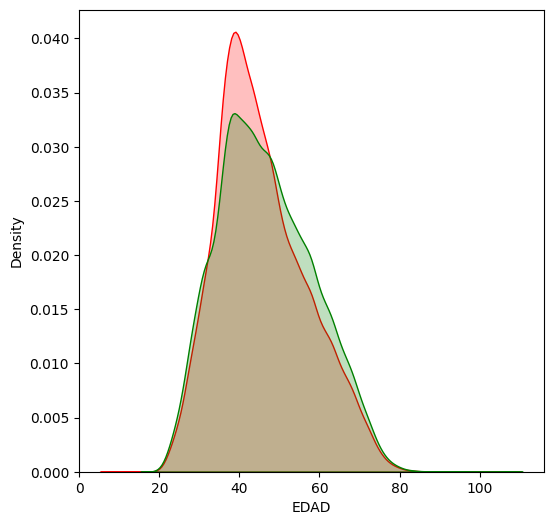

In [10]:
plt.figure(figsize = (6, 6))
fig = sns.kdeplot(Data['EDAD'],fill=True,color = 'red')
fig = sns.kdeplot(df_merge['EDAD'],fill=True,color = 'green')
plt.show()

In [14]:
from sklearn.model_selection import train_test_split
X = Data.drop(['TARGET','ID'], axis=1)
y = Data['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)

In [15]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import RandomOverSampler

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, Param = False):
    # Aplicar oversampling solo al conjunto de entrenamiento
    #oversampler = RandomOverSampler(random_state=42)
    #X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)
    X_train_resampled = X_train.copy()
    y_train_resampled = y_train.copy() 
    # Fit del modelo al conjunto de entrenamiento
    model.fit(X_train_resampled, y_train_resampled)

    # Predecir probabilidades en el conjunto de prueba
    y_prob = model.predict_proba(X_test)[:, 1]

    # Calcular el AUC en el conjunto de entrenamiento
    auc_train = roc_auc_score(y_train_resampled, model.predict_proba(X_train_resampled)[:, 1])
    print(f'AUC Train {type(model).__name__}: {auc_train:.4f}')

    # Evaluar el rendimiento del modelo en el conjunto de prueba usando AUC
    auc_test = roc_auc_score(y_test, y_prob)
    print(f'AUC Test {type(model).__name__}: {auc_test:.4f}')

    # Predecir en el conjunto de prueba
    y_pred = model.predict(X_test)

    # Train F1-Score
    y_train_pred = model.predict(X_train_resampled)
    f1_train = f1_score(y_train_resampled, y_train_pred, average='macro')
    print(f'F1-Score Train {type(model).__name__}: {f1_train:.4f}')

    # Test F1-Score
    y_test_pred = model.predict(X_test)
    f1_test = f1_score(y_test, y_test_pred, average='macro')
    print(f'F1-Score Test {type(model).__name__}: {f1_test:.4f}')
    
    # Calcular y mostrar la matriz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f"Matriz de Confusión para {type(model).__name__}:")
    print(conf_matrix)

    # Calcular y mostrar la precisión (accuracy)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Precisión {type(model).__name__}: {accuracy:.4f}')
    if (Param == True):
        return model.predict_proba(X_test)[:, 1]
# Ejemplo de uso con RandomForestClassifier
#random_forest_model = RandomForestClassifier()
#train_and_evaluate_model(random_forest_model, X_train, y_train, X_test, y_test)

# Ejemplo de uso con XGBClassifier
#xgboost_model = XGBClassifier()
#train_and_evaluate_model(xgboost_model, X_train, y_train, X_test, y_test)

# Ejemplo de uso con CatBoostClassifier
#catboost_model = CatBoostClassifier()
#train_and_evaluate_model(catboost_model, X_train, y_train, X_test, y_test)


In [16]:
# Ejemplo de uso con LGBMClassifier
lgbm_model = LGBMClassifier()
train_and_evaluate_model(lgbm_model, X_train, y_train, X_test, y_test)

[LightGBM] [Info] Number of positive: 9526, number of negative: 54302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.243217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 73340
[LightGBM] [Info] Number of data points in the train set: 63828, number of used features: 586
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.149245 -> initscore=-1.740536
[LightGBM] [Info] Start training from score -1.740536
AUC Train LGBMClassifier: 0.8913
AUC Test LGBMClassifier: 0.8405
F1-Score Train LGBMClassifier: 0.7395
F1-Score Test LGBMClassifier: 0.7001
Matriz de Confusión para LGBMClassifier:
[[22667   536]
 [ 2723  1429]]
Precisión LGBMClassifier: 0.8809


In [17]:
# Eliminar variables correlacionadas

def eliminar_variables_correlacionadas(df, umbral_correlacion=0.7, seed=None):
    """
    Analiza la correlación entre variables en un DataFrame.
    Elimina una de las variables en cada par correlacionado y devuelve la lista final de variables.

    Parameters:
    - df (pd.DataFrame): DataFrame con las variables.
    - umbral_correlacion (float): Umbral de correlación para considerar variables correlacionadas.
    - seed (int): Semilla para reproducibilidad.

    Returns:
    - Lista final de variables sin correlación.
    """
    # Calcula la matriz de correlación
    matriz_correlacion = df.corr().abs()

    # Encuentra las variables correlacionadas
    variables_correlacionadas = []
    for i in range(len(matriz_correlacion.columns)):
        for j in range(i):
            if matriz_correlacion.iloc[i, j] > umbral_correlacion:
                variables_correlacionadas.append((matriz_correlacion.columns[i], matriz_correlacion.columns[j]))

    # Elimina una variable de cada par correlacionado
    variables_a_eliminar = set()
    np.random.seed(seed)
    for par in variables_correlacionadas:
        variable_a_eliminar = np.random.choice(par)
        variables_a_eliminar.add(variable_a_eliminar)

    # Crea la lista final de variables sin correlación
    variables_sin_correlacion = list(set(df.columns) - variables_a_eliminar)

    return variables_sin_correlacion, variables_correlacionadas

# Ejemplo de uso:
# df es tu DataFrame
#variables_sin_correlacion,variables_correlacionadas = eliminar_variables_correlacionadas(df_final[vars_predict])
#print("Cantidad de variables inicial:", len(vars_predict))
#print("Cantidad de variables sin correlación:", len(variables_sin_correlacion))
#print("variables correlacionadas:", variables_correlacionadas)
#print("Variables sin correlación:", variables_sin_correlacion)

In [18]:
# Ejemplo de uso:
# df es tu DataFrame
vars_predict = list(X.columns)
variables_sin_correlacion,variables_correlacionadas = eliminar_variables_correlacionadas(X, umbral_correlacion = 0.9)
print("Cantidad de variables inicial:", len(vars_predict))
print("Cantidad de variables sin correlación:", len(variables_sin_correlacion))
print("variables correlacionadas:", variables_correlacionadas)
print("Variables sin correlación:", variables_sin_correlacion)

Cantidad de variables inicial: 595
Cantidad de variables sin correlación: 48
variables correlacionadas: [('CANT_EMP_NEG_max_2meses', 'CANT_EMP_NEG_mean_2meses'), ('CANT_EMP_NEG_moda_2meses', 'CANT_EMP_NEG_mean_2meses'), ('CANT_EMP_NEG_moda_2meses', 'CANT_EMP_NEG_max_2meses'), ('CANT_EMP_NEG_median_2meses', 'CANT_EMP_NEG_mean_2meses'), ('CANT_EMP_NEG_median_2meses', 'CANT_EMP_NEG_max_2meses'), ('CANT_EMP_NEG_median_2meses', 'CANT_EMP_NEG_moda_2meses'), ('CANT_EMP_CONS_max_2meses', 'CANT_EMP_CONS_mean_2meses'), ('CANT_EMP_CONS_moda_2meses', 'CANT_EMP_CONS_mean_2meses'), ('CANT_EMP_CONS_moda_2meses', 'CANT_EMP_CONS_max_2meses'), ('CANT_EMP_CONS_median_2meses', 'CANT_EMP_CONS_mean_2meses'), ('CANT_EMP_CONS_median_2meses', 'CANT_EMP_CONS_max_2meses'), ('CANT_EMP_CONS_median_2meses', 'CANT_EMP_CONS_moda_2meses'), ('CANT_EMP_HIPOT_max_2meses', 'CANT_EMP_HIPOT_mean_2meses'), ('CANT_EMP_HIPOT_moda_2meses', 'CANT_EMP_HIPOT_mean_2meses'), ('CANT_EMP_HIPOT_moda_2meses', 'CANT_EMP_HIPOT_max_2meses'

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X[variables_sin_correlacion], y, test_size = 0.3, random_state = 100)

In [21]:
lgbm_model = LGBMClassifier()
train_and_evaluate_model(lgbm_model, X_train, y_train, X_test, y_test)

[LightGBM] [Info] Number of positive: 9526, number of negative: 54302
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5973
[LightGBM] [Info] Number of data points in the train set: 63828, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.149245 -> initscore=-1.740536
[LightGBM] [Info] Start training from score -1.740536
AUC Train LGBMClassifier: 0.8437
AUC Test LGBMClassifier: 0.8068
F1-Score Train LGBMClassifier: 0.6802
F1-Score Test LGBMClassifier: 0.6454
Matriz de Confusión para LGBMClassifier:
[[22671   532]
 [ 3106  1046]]
Precisión LGBMClassifier: 0.8670


In [22]:
# Ejemplo de uso con CatBoostClassifier
catboost_model = CatBoostClassifier()
train_and_evaluate_model(catboost_model, X_train, y_train, X_test, y_test)

Learning rate set to 0.060768
0:	learn: 0.6479159	total: 245ms	remaining: 4m 5s
1:	learn: 0.6104512	total: 280ms	remaining: 2m 19s
2:	learn: 0.5781316	total: 314ms	remaining: 1m 44s
3:	learn: 0.5494898	total: 340ms	remaining: 1m 24s
4:	learn: 0.5252214	total: 365ms	remaining: 1m 12s
5:	learn: 0.5021026	total: 389ms	remaining: 1m 4s
6:	learn: 0.4833647	total: 419ms	remaining: 59.4s
7:	learn: 0.4679459	total: 448ms	remaining: 55.6s
8:	learn: 0.4525791	total: 482ms	remaining: 53.1s
9:	learn: 0.4394061	total: 517ms	remaining: 51.1s
10:	learn: 0.4293276	total: 550ms	remaining: 49.4s
11:	learn: 0.4192687	total: 576ms	remaining: 47.4s
12:	learn: 0.4114151	total: 601ms	remaining: 45.6s
13:	learn: 0.4047175	total: 629ms	remaining: 44.3s
14:	learn: 0.3983156	total: 655ms	remaining: 43s
15:	learn: 0.3926126	total: 688ms	remaining: 42.3s
16:	learn: 0.3881307	total: 720ms	remaining: 41.6s
17:	learn: 0.3842668	total: 752ms	remaining: 41s
18:	learn: 0.3798368	total: 787ms	remaining: 40.6s
19:	learn: 

In [23]:
# Ejemplo de uso con XGBClassifier
xgboost_model = XGBClassifier()
train_and_evaluate_model(xgboost_model, X_train, y_train, X_test, y_test)

AUC Train XGBClassifier: 0.8712
AUC Test XGBClassifier: 0.7997
F1-Score Train XGBClassifier: 0.7215
F1-Score Test XGBClassifier: 0.6489
Matriz de Confusión para XGBClassifier:
[[22581   622]
 [ 3057  1095]]
Precisión XGBClassifier: 0.8655


## Random Forest

In [31]:
X = Data.drop(['TARGET','ID'], axis=1)
y = Data['TARGET']

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)

## Tuneo Hiperparámetros

In [26]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
import pandas as pd

def train_and_evaluate_model_Tuneo(model, param_dist, X_train, y_train, X_test, y_test):
    # Aplicar oversampling solo al conjunto de entrenamiento
    #oversampler = RandomOverSampler(random_state=42)
    #X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)
    X_train_resampled = X_train.copy()
    y_train_resampled = y_train.copy()
    # Inicializar el modelo con hiperparámetros dados o por defecto
    model_instance = model(**param_dist, random_state=42)

    # Realizar la búsqueda aleatoria para el modelo en el conjunto de entrenamiento oversampleado
    random_search_model = RandomizedSearchCV(model_instance, param_distributions=param_dist, n_iter=100, cv=3, scoring='f1_macro', random_state=123)
    random_search_model.fit(X_train_resampled, y_train_resampled)

    # Obtener el mejor modelo
    best_model = random_search_model.best_estimator_

    # Predecir probabilidades en el conjunto de prueba
    y_prob_Test = best_model.predict_proba(X_test)[:, 1]

    y_prob_Train = best_model.predict_proba(X_train_resampled)[:, 1]

    auc_train = roc_auc_score(y_train_resampled, y_prob_Train)
    print(f'AUC Train{type(best_model).__name__} con Optimización y Oversampling: {auc_train:.4f}')

    # Evaluar el rendimiento del modelo en el conjunto de prueba original usando AUC
    auc_test = roc_auc_score(y_test, y_prob_Test)
    print(f'AUC Test{type(best_model).__name__} con Optimización y Oversampling: {auc_test:.4f}')
    
    # Predecir en el conjunto de prueba
    y_pred = best_model.predict(X_test)

    # Calcular y mostrar la matriz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(f"Matriz de Confusión para {type(best_model).__name__}:")
    print(conf_matrix)

    # Train F1-Score
    y_train_pred = best_model.predict(X_train_resampled)
    f1_train = f1_score(y_train_resampled, y_train_pred, average='macro')
    print(f'F1-Score Train {type(model).__name__}: {f1_train:.4f}')

    # Test F1-Score
    y_test_pred = best_model.predict(X_test)
    f1_test = f1_score(y_test, y_test_pred, average='macro')
    print(f'F1-Score Test {type(model).__name__}: {f1_test:.4f}')
    
    # Calcular y mostrar la precisión (accuracy)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Precisión {type(best_model).__name__} con Optimización y Oversampling: {accuracy:.4f}')

    # Imprimir los mejores hiperparámetros encontrados
    print(f"Mejores hiperparámetros {type(best_model).__name__}:", random_search_model.best_params_)

    model_evaluation(best_model, X_train, X_test, y_train, y_test, type(best_model).__name__)



AUC TrainXGBClassifier con Optimización y Oversampling: 0.9045
AUC TestXGBClassifier con Optimización y Oversampling: 0.7946
Matriz de Confusión para XGBClassifier:
[[22536   667]
 [ 3044  1108]]
F1-Score Train type: 0.7603
F1-Score Test type: 0.6489
Precisión XGBClassifier con Optimización y Oversampling: 0.8643
Mejores hiperparámetros XGBClassifier: {'learning_rate': 0.2, 'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 121, 'subsample': 0.9}

	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     54302
           1       0.88      0.43      0.57      9526

    accuracy                           0.91     63828
   macro avg       0.89      0.71      0.76     63828
weighted avg       0.90      0.91      0.89     63828


	   Classification report for test set
-------------------------------------------------------
              precision

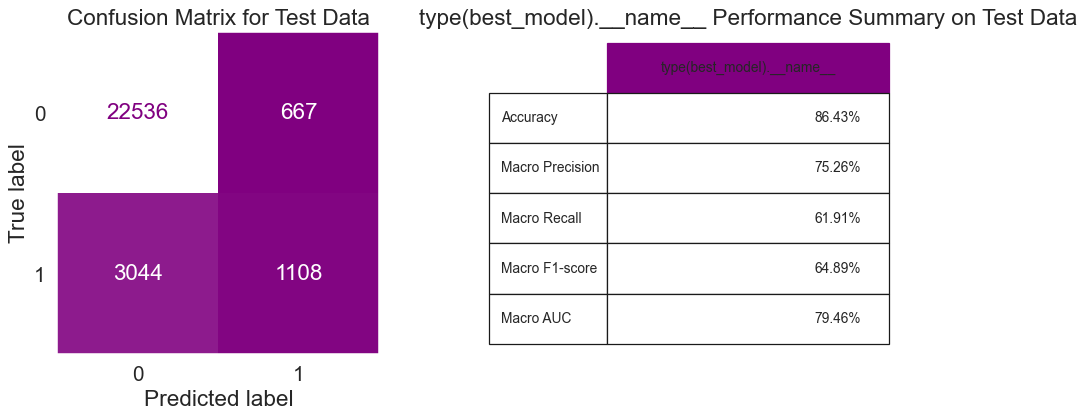

In [25]:
# Ejemplo de uso con XGBoost
param_dist_xgboost = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 10),
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'min_child_weight': randint(1, 10),
}

train_and_evaluate_model_Tuneo(xgb.XGBClassifier, param_dist_xgboost, X_train, y_train, X_test, y_test)

In [54]:
bestXGB = xgb.XGBClassifier(learning_rate = 0.2, 
                            max_depth = 8, min_child_weight = 1, 
                            n_estimators = 178, 
                            subsample = 0.8  
                )

In [65]:
train_and_evaluate_model(bestXGB, X_train, y_train, X_test, y_test)

AUC Train XGBClassifier: 0.9710
AUC Test XGBClassifier: 0.7844
F1-Score Train XGBClassifier: 0.9085
F1-Score Test XGBClassifier: 0.6738
Matriz de Confusión para XGBClassifier:
[[19907  3296]
 [ 1907  2245]]
Precisión XGBClassifier: 0.8098


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 6351, number of negative: 36201
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5784
[LightGBM] [Info] Number of data points in the train set: 42552, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.149253 -> initscore=-1.740474
[LightGBM] [Info] Start training from score -1.740474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

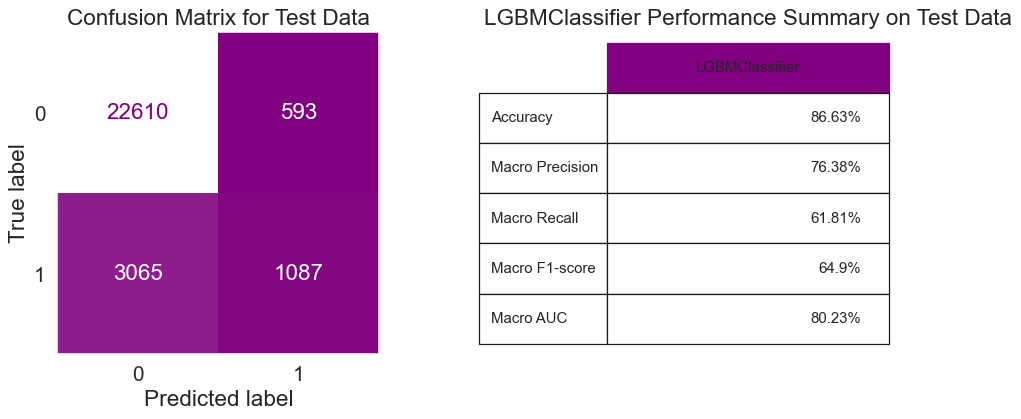

In [27]:
# Ejemplo de uso con LightGBM
param_dist_lgbm = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 10),
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'min_child_weight': randint(1, 10),
    'reg_alpha': randint(0,5),
    'reg_lambda': randint(0,5)
}
train_and_evaluate_model_Tuneo(lgb.LGBMClassifier, param_dist_lgbm, X_train, y_train, X_test, y_test)


In [118]:
bestLGBM = lgb.LGBMClassifier(learning_rate = 0.2, 
                            max_depth =7, min_child_weight = 7, 
                            n_estimators = 183, 
                            subsample = 1.0,
                            reg_alpha = 3,
                            reg_lambda = 1
                )

In [119]:
predict_test_lg = train_and_evaluate_model(bestLGBM, X_train, y_train, X_test, y_test, Param = True)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 9526, number of negative: 54302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5602
[LightGBM] [Info] Number of data points in the train set: 63828, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.149245 -> initscore=-1.740536
[LightGBM] [Info] Start training from score -1.740536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

0:	learn: 0.5606088	total: 73.6ms	remaining: 11.6s
1:	learn: 0.4757120	total: 135ms	remaining: 10.6s
2:	learn: 0.4256096	total: 192ms	remaining: 10s
3:	learn: 0.3968461	total: 253ms	remaining: 9.79s
4:	learn: 0.3760982	total: 323ms	remaining: 9.95s
5:	learn: 0.3649692	total: 382ms	remaining: 9.75s
6:	learn: 0.3577001	total: 438ms	remaining: 9.51s
7:	learn: 0.3511865	total: 500ms	remaining: 9.43s
8:	learn: 0.3451098	total: 559ms	remaining: 9.31s
9:	learn: 0.3410457	total: 619ms	remaining: 9.23s
10:	learn: 0.3375168	total: 678ms	remaining: 9.12s
11:	learn: 0.3355926	total: 734ms	remaining: 8.99s
12:	learn: 0.3340187	total: 791ms	remaining: 8.89s
13:	learn: 0.3325305	total: 849ms	remaining: 8.79s
14:	learn: 0.3309691	total: 912ms	remaining: 8.75s
15:	learn: 0.3301467	total: 964ms	remaining: 8.62s
16:	learn: 0.3292327	total: 1.02s	remaining: 8.52s
17:	learn: 0.3285210	total: 1.07s	remaining: 8.42s
18:	learn: 0.3276957	total: 1.13s	remaining: 8.33s
19:	learn: 0.3271833	total: 1.18s	remainin

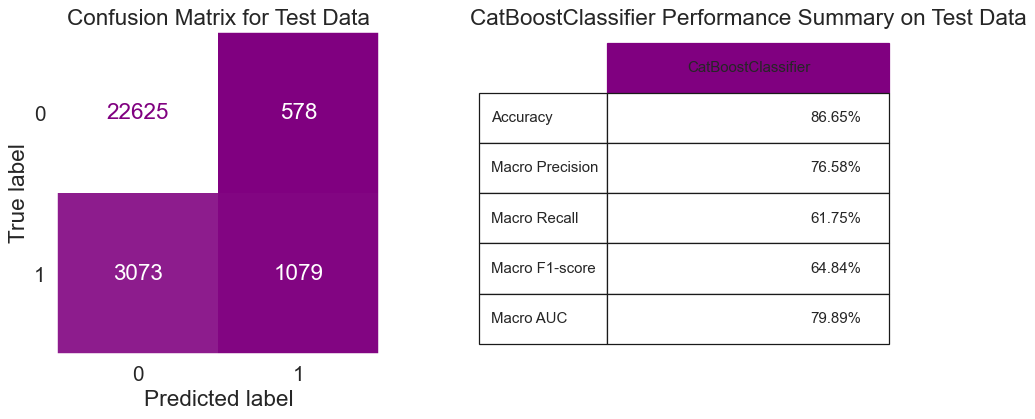

In [33]:
from catboost import CatBoostClassifier
# Definir los espacios de búsqueda de hiperparámetros para CatBoost
param_dist_catboost = {
    'iterations': randint(50, 200),       # Número de iteraciones (árboles)
    'depth': randint(3, 10),              # Profundidad máxima de cada árbol
    'learning_rate': [0.01, 0.1, 0.2],    # Tasa de aprendizaje
    'subsample': [0.8, 0.9, 1.0],         # Proporción de muestras utilizadas para entrenar cada árbol
    'min_child_samples': randint(1, 10),   # Mínimo de muestras en cada hoja
}
# Inicializar el modelo de CatBoost
#modelo_catboost = CatBoostClassifier(random_state=42, verbose=0)
train_and_evaluate_model_Tuneo(CatBoostClassifier, param_dist_catboost, X_train, y_train, X_test, y_test)

In [120]:
# Optimizamos el umbral
# Importamos la métrica f1_score
from sklearn.metrics import f1_score

# Definimos una lista vacía
Result = []
for umbral in np.arange(0.20, 1.0, 0.01).tolist():
    predicciones_binarias = (predict_test_lg > umbral).astype(int)*1
    f_score = f1_score(y_test, predicciones_binarias, average = 'macro')
    Result.append((umbral, f_score))

# Encuentra el umbral que maximiza el F-score
umbral_optimo, f_score_maximo = max(Result, key=lambda x: x[1])[0], max(Result, key=lambda x: x[1])[1]
print(f'Umbral óptimo: {umbral_optimo}')
print(f'Máximo valor de F-score: {f_score_maximo}')

Umbral óptimo: 0.3300000000000001
Máximo valor de F-score: 0.6934403771623604
